In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
%cd /content/drive/MyDrive/graduation_project/FPTT-on-ANN/RNN/lstm-master/lab1-solution/notebooks/
!pwd

/content/drive/MyDrive/graduation_project/FPTT-on-ANN/RNN/lstm-master/lab1-solution/notebooks
/content/drive/MyDrive/graduation_project/FPTT-on-ANN/RNN/lstm-master/lab1-solution/notebooks


In [3]:
import numpy as np
import copy
import matplotlib.pyplot as plt

In [4]:
def LoadData(DirName,limit = 500):
    data = list();
    count = 0;
    with open(DirName) as f:
        for line in f:
            if count<limit:
                new_line = np.array(line.split(','))
                new_line = new_line.astype(np.float32)
                data.append(new_line)
                count += 1
    data = np.asarray(data)
    
    return data[:,0],data[:,1:]

NoTrain = 60000
NoTest = 10000
Y_train,x_train = LoadData("../data/mnist_train.csv", NoTrain)
Y_test,x_test = LoadData("../data/mnist_test.csv", NoTest)

print(f"Test set size: {x_test.shape[0]} x {x_test.shape[1]}")
print(f"Train set size: {x_train.shape[0]} x {x_train.shape[1]}")

Test set size: 10000 x 784
Train set size: 60000 x 784


In [5]:
x_train_st = (x_train-np.average(x_train))/np.std(x_train)
x_test_st = (x_test-np.average(x_train))/np.std(x_train)

In [6]:
# One-hot encoding train and test sets labels 
y_train = np.zeros((Y_train.size, int(Y_train.max()) + 1))
# y_train = np.zeros((Y_train.size, 10))
y_train[np.arange(Y_train.size),Y_train.astype(int)] = 1.0;

y_test  = np.zeros((Y_test.size, int(Y_test.max()) + 1))
# y_test  = np.zeros((Y_test.size, 10))
y_test[np.arange(Y_test.size),Y_test.astype(int)] = 1.0;

print(f"Your decimal label is {Y_train[0]:.0f} and your one-hot encoded label is {y_train[0,:]}")
print(f"Correct decimal label is 5 and correct one-hot encoded label is [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]")

Your decimal label is 5 and your one-hot encoded label is [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Correct decimal label is 5 and correct one-hot encoded label is [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [7]:
X = x_train_st 
Y = y_train 

N_l = 128  # number of neurons in hidden layer

layers = np.array([1] +[N_l]+[Y.shape[1]]) # 

print(X.shape)
print('Your', '\033[1m' + 'layers' + '\033[0m','array is:', layers)

(60000, 784)
Your layers array is: [  1 128  10]


##Definition

In [8]:
np.random.seed(seed=0)

def init_weights(layers):
    weights = list()
    
    weights_l1 = {}
    weights_l1["wi"] = np.random.uniform(-1,1,size=[(layers[0]+layers[1]),layers[1]])  # weights for recurrent hidden layer (LSTM), input gate
    weights_l1["wf"] = np.random.uniform(-1,1,size=[(layers[0]+layers[1]),layers[1]])  # weights for recurrent hidden layer (LSTM), forget gate
    weights_l1["wg"] = np.random.uniform(-1,1,size=[(layers[0]+layers[1]),layers[1]])  # weights for recurrent hidden layer (LSTM), candidate gate
    weights_l1["wo"] = np.random.uniform(-1,1,size=[(layers[0]+layers[1]),layers[1]])  # weights for recurrent hidden layer (LSTM), output gate

    weights.append(weights_l1)
    #for output layer
    weights_l2 = np.random.uniform(-1,1,size=[layers[1],layers[2]])  # weights for output layer
    weights.append(weights_l2)
    
    weights = np.asarray(weights,dtype=object)
    return weights


eg_weights = init_weights(layers)
print(eg_weights[0]["wi"].shape)
print(eg_weights[1].shape)


(129, 128)
(128, 10)


In [9]:
def init_weights_derivatives(layers, weights):

    ''' initiate gradient ''' 
    # hidden layer 
    w_g_l1 = {}
    w_g_l1["wi"] = np.zeros(((layers[0]+layers[1]),layers[1]))  # weights derivatives for recurrent hidden layer (LSTM), input gate
    w_g_l1["wf"] = np.zeros(((layers[0]+layers[1]),layers[1]))  # weights derivatives for recurrent hidden layer (LSTM), forget gate
    w_g_l1["wg"] = np.zeros(((layers[0]+layers[1]),layers[1]))  # weights derivatives for recurrent hidden layer (LSTM), candidate gate
    w_g_l1["wo"] = np.zeros(((layers[0]+layers[1]),layers[1]))  # weights derivatives for recurrent hidden layer (LSTM), output gate
    # output layer
    w_g_l2 = np.zeros((layers[1],layers[2]))  # weights derivatives for output layer

    w_g = list()
    w_g.append(w_g_l1)
    w_g.append(w_g_l2)
    w_g = np.asarray(w_g,dtype=object)

    ''' initiate lambda ''' 
    # hidden layer 
    w_lbd_l1 = {}
    w_lbd_l1["wi"] = np.zeros(((layers[0]+layers[1]),layers[1]))  # running estimate for recurrent hidden layer (LSTM), input gate
    w_lbd_l1["wf"] = np.zeros(((layers[0]+layers[1]),layers[1]))  # running estimate for recurrent hidden layer (LSTM), forget gate
    w_lbd_l1["wg"] = np.zeros(((layers[0]+layers[1]),layers[1]))  # running estimate for recurrent hidden layer (LSTM), candidate gate
    w_lbd_l1["wo"] = np.zeros(((layers[0]+layers[1]),layers[1]))  # running estimate for recurrent hidden layer (LSTM), output gate
    # output layer
    w_lbd_l2 = np.zeros((layers[1],layers[2]))  # weights derivatives for output layer

    w_lbd = list()
    w_lbd.append(w_lbd_l1)
    w_lbd.append(w_lbd_l2)
    w_lbd = np.asarray(w_lbd,dtype=object)


    ''' initiate running mean''' 
    # initial running means of weights are same as weights 
    w_rm = copy.deepcopy(weights)


    return w_g, w_lbd, w_rm


eg_w_g,_,_ = init_weights_derivatives(layers, eg_weights)
print(eg_w_g[0]["wi"].shape, eg_w_g[1].shape)



(129, 128) (128, 10)


In [10]:
def ReLU(x):
    """Input Parameters:x : input: float of array  Returns:ReLU(x) : float or array"""

    y = np.maximum(0, x)
    return y

def sigmoid(x):
    """ Input Parameters: x : input: float of array  Returns: sigmoid(x) : float or array """

    y = 1./(1.+np.exp(-x))
    return y

def softmax(x):  
    """ Input Parameters: x : input: array(n x p) : n samples by p dimensions : p=10 for MNIST (because we have 0-9 digits)  Returns: softmax(x) : float or array """
    
    y = np.exp(x)/np.exp(x).sum(axis=1,keepdims= True)
    return y

In [11]:
# Initialization of the layer outputs

def init_layer(layers,n_samples):

    # internal states of LSTM layer (hidden layer)
    LSTM_internal_states = {}
    LSTM_internal_states["xc"] = np.empty((n_samples,(layers[0] + layers[1]))) 
    LSTM_internal_states["i"] = np.empty((n_samples,layers[1])) 
    LSTM_internal_states["f"] = np.empty((n_samples,layers[1])) 
    LSTM_internal_states["o"] = np.empty((n_samples,layers[1])) 
    LSTM_internal_states["g"] = np.empty((n_samples,layers[1])) 
    LSTM_internal_states["s"] = np.zeros((n_samples,layers[1])) 
    LSTM_internal_states["s_prev"] = np.zeros((n_samples,layers[1])) 
    LSTM_internal_states["h_prev"] = np.zeros((n_samples,layers[1])) 
    
    h = [np.zeros((n_samples,layers[1])),np.empty((n_samples,layers[2]))] 

    o = [np.empty((n_samples,layers[0])),np.empty((n_samples,layers[1])),np.empty((n_samples,layers[2]))] 
    return LSTM_internal_states, h,o

eg_ins, eg_h,eg_o = init_layer(layers,500)

print(eg_ins["h_prev"].shape, eg_o[2].shape)
print(f"h size (hidden layer): {eg_h[0].shape[0]} x {eg_h[0].shape[1]}")

(500, 128) (500, 10)
h size (hidden layer): 500 x 128


In [12]:
def feedforward(data, weights, ins, o, h):
    
    # Input layer
    o[0] = data
    
    # Hidden layer --> ReLU activation
    ins["s_prev"] = ins["s"]
    ins["h_prev"] = h[0]
    
    ins["xc"] = np.hstack((o[0], ins["h_prev"]))
    ins["i"] = sigmoid(np.dot(ins["xc"], weights[0]["wi"])) # (500,128) = (500,129)(129,128)
    ins["f"] = sigmoid(np.dot(ins["xc"], weights[0]["wf"])) # (500,128) = (500,129)(129,128)
    ins["o"] = sigmoid(np.dot(ins["xc"], weights[0]["wo"])) # (500,128) = (500,129)(129,128)
    ins["g"] = np.tanh(np.dot(ins["xc"], weights[0]["wg"])) # (500,128) = (500,129)(129,128)
    ins["s"] = ins["g"]*ins["i"] + ins["s_prev"]*ins["f"]
    h[0] = ins["s"] * ins["o"]
    o[1] = h[0] # no activation function



    
    # Output Layer --> sigmoid + softmax activations
    h[1] = o[1].dot(weights[1]) # (500,128) (128,10)
    o[2] = sigmoid(h[1])
    Y_hat = softmax(o[2]) 
    
    return Y_hat

# print(X[:,0:1].shape)
# Y_hat = feedforward(X[:,0:1], weights,ins,o,h)
# print(Y_hat.shape)
# with np.printoptions(precision=4, suppress=True):
#     print('Your predicted output for the first training sample is:',Y_hat[0])
# print('Correct predicted output for the first training sample is: [0.0593 0.1611 0.0593 0.1611 0.0593 0.0593 0.1611 0.0593 0.1611 0.0593]')


In [13]:
#cross entropy loss  
def cross_entropy(y_pred,y):
    """ Input Parameters: y_pred, y : array of float  Returns: c : float """
    
    # Compute loss
    c = ((-np.log(y_pred))*y).sum(axis=1).sum()

    print(y_pred, y, c)
    return c

# loss = cross_entropy(Y_hat,Y)
# print(f"Your loss with randomly initilized weights is {loss:.3f}")
# print(f"Correct loss with randomly initilized weights is 143488.412")

In [14]:
def labeling(x):  
    # Set the label with the max probability to '1' and the rest to 0 
    label = np.zeros((x.shape[0],Y.shape[1]))
    label[np.arange(x.shape[0]),x.argmax(axis=1)] = 1
    return label

def accuracy(y_pred,y):  
    # Calculate the accuracy along the rows, averaging the results over the number of samples.
    acc = np.all(y_pred==y,axis=1).mean()
    return acc

# acc = accuracy(labeling(Y_hat),Y)
# print(f"Your accuracy with randomly initialized weights is {acc:.4f}")
# print(f"Correct accuracy with randomly initialized weights is 0.1163")

In [15]:
def sigmoid_prime(x):
    # Compute the derivative of sigmoid where h=sigmoid(x)
    derivative = sigmoid(x)*(1-sigmoid(x)) 
    return derivative

def tanh_prime(values): 
    return 1. - values ** 2

In [16]:
# def backpropagation(Y,Y_hat,weights,h,o):
#     delta = [np.empty((Y.shape[0],weights[0].shape[1])),np.empty((Y.shape[0],weights[1].shape[1]))]
#     dC_dw = [np.empty((weights[0].shape[0],weights[0].shape[1])),np.empty((weights[1].shape[0],weights[1].shape[1]))]
#     # print(Y_hat.shape)
#     # Calculate d(L,w1)
#     delta[1] = (Y_hat - Y)*sigmoid_prime(h[1])
#     dC_dw[1] = o[1].T.dot(delta[1])
    
#     # Calculate d(L,w0)
#     delta[0] = (delta[1].dot(weights[1].T))*ReLU_prime(h[0])
#     dC_dw[0] = o[0].T.dot(delta[0])
    
#     return dC_dw

In [17]:
# truncation 0 
def backpropagation2(Y, Y_hat, weights, ins, h, o, w_diff):

    ''' comments below is the exmaple derivation of maxtrix size 
        batch size: 500; layers: 1-128-10 '''
    
    # gradient of Loss function w.r.t. h[0](hidden layer), h[1](output layer)
    # (500, 128) (500, 10)
    dh = [np.empty((Y.shape[0],weights[0]["wi"].shape[1])),np.empty((Y.shape[0],weights[1].shape[1]))]

    # (500,10) = (500, 10)*(500,10)
    dh[1] = (Y_hat - Y)*sigmoid_prime(h[1]) 
    # (128,10)=(128,500)x(500,10)
    w_diff[1] = o[1].T.dot(dh[1])

    # (500,128) = (500,10)x(10,128)*(500,128)
    dh[0] = (dh[1].dot(weights[1].T)) # *sigmoid_prime(h[0])
    # (500,128) = (500,128)x(500,128)
    ds = ins["o"] * dh[0]

    # (500,128) = (500,128) * (500,128) 
    do = ins["s"] * dh[0]
    # (500,128) = (500,128)*(500,128)
    do_input = sigmoid_prime(ins["o"]) *do
    # (129,128) = (129,500)*(500,128)
    w_diff[0]["wo"] = np.dot(ins["xc"].T,  do_input)

    #(500,128)
    di = ins["g"] * ds
    df = ins["s_prev"] * ds
    dg = ins["i"] *ds

    #(500,128)
    di_input = sigmoid_prime(ins["i"]) * di
    df_input = sigmoid_prime(ins["f"]) * df
    dg_input = tanh_prime(ins["g"]) * dg

    #(129,128) = (129,500)*(500,128)
    w_diff[0]["wi"] = np.dot(ins["xc"].T, di_input)
    w_diff[0]["wf"] = np.dot(ins["xc"].T, df_input)
    w_diff[0]["wg"] = np.dot(ins["xc"].T, dg_input)


In [18]:
def apply_diff(lr, weights, w_diff):

    weights[1] -= lr* w_diff[1]
    weights[0]["wi"] -= lr * w_diff[0]["wi"]
    weights[0]["wf"] -= lr * w_diff[0]["wf"]
    weights[0]["wg"] -= lr * w_diff[0]["wg"]
    weights[0]["wo"] -= lr * w_diff[0]["wo"]


In [19]:
def apply_diff_fptt(lr, alpha, weights, w_g, w_lbd, w_rm):

    weights[1]       -= lr * (w_g[1] - w_lbd[1] + alpha*(weights[1] - w_rm[1]))
    weights[0]["wi"] -= lr * (w_g[0]["wi"] - w_lbd[0]["wi"] + alpha*(weights[0]["wi"] - w_rm[0]["wi"] ))
    weights[0]["wf"] -= lr * (w_g[0]["wf"] - w_lbd[0]["wf"] + alpha*(weights[0]["wf"] - w_rm[0]["wf"] ))
    weights[0]["wg"] -= lr * (w_g[0]["wg"] - w_lbd[0]["wg"] + alpha*(weights[0]["wg"] - w_rm[0]["wg"] ))
    weights[0]["wo"] -= lr * (w_g[0]["wo"] - w_lbd[0]["wo"] + alpha*(weights[0]["wo"] - w_rm[0]["wo"] ))

    w_lbd[1] -= alpha*(weights[1] - w_rm[1])
    w_lbd[0]["wi"] -= alpha*(weights[0]["wi"] - w_rm[0]["wi"])
    w_lbd[0]["wf"] -= alpha*(weights[0]["wf"] - w_rm[0]["wf"])
    w_lbd[0]["wg"] -= alpha*(weights[0]["wg"] - w_rm[0]["wg"])
    w_lbd[0]["wo"] -= alpha*(weights[0]["wo"] - w_rm[0]["wo"])

    w_rm[1] = 0.5*(w_rm[1] + weights[1]) -(0.5/alpha) * w_lbd[1]
    w_rm[0]["wi"] = 0.5*(w_rm[0]["wi"] + weights[0]["wi"]) - (0.5/alpha) * w_lbd[0]["wi"]
    w_rm[0]["wf"] = 0.5*(w_rm[0]["wf"] + weights[0]["wf"]) - (0.5/alpha) * w_lbd[0]["wf"]
    w_rm[0]["wg"] = 0.5*(w_rm[0]["wg"] + weights[0]["wg"]) - (0.5/alpha) * w_lbd[0]["wg"]
    w_rm[0]["wo"] = 0.5*(w_rm[0]["wo"] + weights[0]["wo"]) - (0.5/alpha) * w_lbd[0]["wo"]



In [42]:
## Mini-batch gradient descent
np.random.seed(seed=0)

X_test = x_test_st[0:1000, :] 
Y_test = y_test[0:1000, :]
n_test = X_test.shape[0]

# lists for saving the value of loss and accuracy of each epoch
mean_train_loss_list = list()
train_acc_list = list()
mean_test_loss_list = list()
test_acc_list = list()

# Initialize the batch size, the number of epochs, and the learning rate
n_samples = 2 #X.shape[0]

batch_size = 1
epochs = 200
lr = 0.0002
alpha = 0.1

# Initialize the weights
weights = init_weights(layers)
w_g, w_lbd, w_rm = init_weights_derivatives(layers, weights)

# Q: predicted label distribution of last training epoch --> used to make auxiliary loss (oracle loss)
Q = np.zeros_like(Y)

target = np.zeros((batch_size, 10))


# Epoch for loop
for epoch in range(epochs):

    # if (epoch==60) or (epoch==90) or (epoch==120):
        # lr *= 0.5

    # Initialize the layers
    ins, h, o = init_layer(layers,batch_size)
   
    # Initialize the training loss and accuracy for each epoch
    train_loss = 0
    train_acc = 0

    # Create a random permutation for shuffling
    shuffle = np.random.permutation(n_samples)
    # print(shuffle[0])


    # Shuffle dataset and create mini-batches for each epoch
    X_batches = np.array_split(X[shuffle],n_samples/batch_size)
    Y_batches = np.array_split(Y[shuffle],n_samples/batch_size)
    Q_batches = np.array_split(Q[shuffle],n_samples/batch_size)
    target = np.empty_like(Q_batches)


    # print(X_batches[0].shape)
    seq_len = int(X_batches[0].shape[1])

    # Mini-batch for loop
    for b in range(int(n_samples/batch_size)):

        # print(f"batch idx: {b}")
        for t in range(seq_len):

            # forward - to get the prediction
            Y_hat_batch= feedforward(X_batches[b][:,t:t+1], weights, ins, o, h)
            # print(X_batches[b][:,t:t+1].shape, ins["i"].shape)


            # to make target for cross entropy and divergence term 
            beta = (t+1)/seq_len 
            target[b] = beta*(Y_batches[b]) + (1-beta)*Q_batches[b]

            # backwards - to calculate the gradients w.r.t. cross entropy loss and auxiliary loss
            backpropagation2(target[b], Y_hat_batch, weights, ins, h, o, w_g)


            # update the weights by gradients obtained
            apply_diff_fptt(lr, alpha, weights, w_g, w_lbd, w_rm)
            # apply_diff(lr, weights, w_g)


        Q[shuffle[batch_size*b:batch_size*(b+1)]] = Q_batches[b]

        train_loss += cross_entropy(Y_hat_batch,Y_batches[b])
        train_acc += accuracy(labeling(Y_hat_batch),Y_batches[b])       

    # Evalute loss and accuracy for the training dataset per epoch
    # mean_train_loss = train_loss
    # train_acc = (train_acc)
    mean_train_loss = train_loss/n_samples
    train_acc = (train_acc/len(X_batches))
    mean_train_loss_list.append(mean_train_loss)
    train_acc_list.append(train_acc)




    # # Predictions for test dataset
    # ins_test, h_test,o_test = init_layer(layers,n_test)
  
    # for j in range(seq_len):
    #     Y_hat_test= feedforward(X_test[:,j:j+1], weights, ins_test, o_test, h_test)



    # # Evaluate loss and accuracy for the test dataset per epoch
    # mean_test_loss = cross_entropy(Y_hat_test,Y_test)/len(Y_test)
    # test_acc = accuracy(labeling(Y_hat_test), Y_test)
    # mean_test_loss_list.append(mean_test_loss)
    # test_acc_list.append(test_acc)

    # Print statistics per epoch
    # print(f"Epoch {epoch+1}: train_loss = {mean_train_loss:.3f} | train_acc = {train_acc:.3f} | test_loss = {mean_test_loss:.3f} | test_acc = {test_acc:.3f}" )
    print(f"Epoch {epoch+1}: train_loss = {mean_train_loss:.3f} | train_acc = {train_acc:.3f} " )


# print(f"\nYour performance after {epochs} epoch(s) is: train_loss = {mean_train_loss:.3f} | train_acc = {train_acc:.3f} | test_loss = {mean_test_loss:.3f} | test_acc = {test_acc:.3f}\n")
# print('Correct performance after 1 epoch is: train_loss = 2.314 | train_acc = 0.150 | test_loss = 2.248 | test_acc = 0.179')
# print('Correct performance after 10 epochs is: train_loss = 1.746 | train_acc = 0.667 | test_loss = 1.731 | test_acc = 0.685')
# print('Correct performance after 50 epochs is: train_loss = 1.592 | train_acc = 0.853 | test_loss = 1.592 | test_acc = 0.861')

[[0.05376796 0.05376797 0.05376796 0.14548766 0.05376796 0.14615648
  0.14615648 0.14615648 0.05481457 0.14615648]] [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]] 1.9230774635543169
[[0.05923095 0.16078189 0.0592311  0.05923096 0.16100342 0.05923095
  0.16100642 0.05923095 0.06004694 0.16100642]] [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] 2.8263110453195153
Epoch 1: train_loss = 2.375 | train_acc = 0.500 
[[0.14360746 0.14396629 0.05296275 0.05296275 0.08315181 0.14312676
  0.05298671 0.14396518 0.13030754 0.05296275]] [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] 1.9406717011760168
[[0.14950114 0.12662561 0.06309007 0.06512614 0.06356338 0.06326131
  0.06309005 0.17115572 0.06309005 0.17149653]] [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]] 2.760481275874008
Epoch 2: train_loss = 2.351 | train_acc = 0.000 
[[0.12566409 0.13491751 0.04971316 0.13513372 0.04971454 0.04974112
  0.135134   0.1351343  0.04971323 0.13513432]] [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] 2.0741428532181883
[[0.11447202 0.11447202 0.11447202 0.11447202 0.0421119  0

<ipython-input-10-2a8545ddb61c>:10: RuntimeWarning: overflow encountered in exp
  y = 1./(1.+np.exp(-x))


[[0.14617974 0.05377652 0.05377652 0.14617974 0.14617974 0.05399484
  0.14617974 0.14617974 0.05377692 0.05377652]] [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]] 2.9188667405802047
Epoch 4: train_loss = 2.319 | train_acc = 0.500 
[[0.09877849 0.12602181 0.15401447 0.10405731 0.05730396 0.13942804
  0.05763382 0.05731762 0.14795488 0.05748959]] [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] 2.314875389292149
[[0.17936718 0.0659855  0.17936718 0.0659855  0.0659855  0.17936718
  0.0659855  0.0659855  0.0659855  0.0659855 ]] [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]] 1.7183203148377744
Epoch 5: train_loss = 2.017 | train_acc = 0.000 
[[0.07837425 0.07262975 0.11332828 0.17648513 0.16097294 0.07490805
  0.07320558 0.07354659 0.07234393 0.10420548]] [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]] 2.591493939794325
[[0.06598531 0.06598531 0.06598531 0.17936666 0.06598532 0.17936666
  0.17936666 0.06598531 0.06598531 0.06598817]] [[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]] 2.7183231861166877
Epoch 6: train_loss = 2.655 | train_acc = 0.000 
[[0.135188

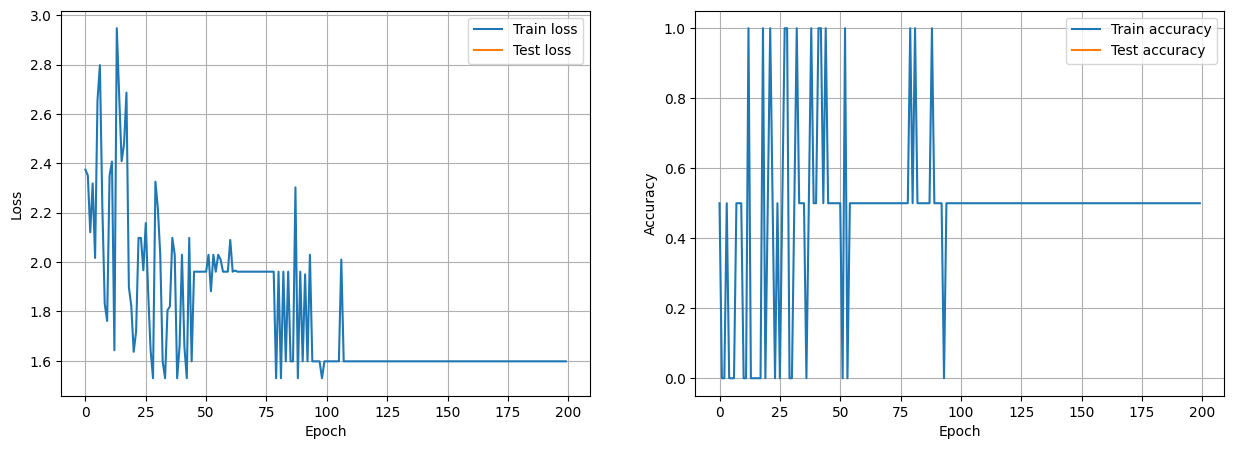

In [43]:
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].plot(mean_train_loss_list,label="Train loss")
ax[0].plot(mean_test_loss_list,label="Test loss")
ax[0].legend()
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].grid()

ax[1].plot(train_acc_list,label="Train accuracy")
ax[1].plot(test_acc_list,label="Test accuracy")
ax[1].legend()
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].grid()

In [22]:
a = np.array([[1,2,3],[4,5,6]])

In [23]:
b = np.array([[1],[1]])

In [24]:
a

array([[1, 2, 3],
       [4, 5, 6]])

In [25]:
b

array([[1],
       [1]])

In [26]:
print(a++b)

[[2 3 4]
 [5 6 7]]


In [27]:
print(np.hstack((a,b)))

[[1 2 3 1]
 [4 5 6 1]]


In [28]:
print(a.shape, b.shape)

(2, 3) (2, 1)


In [29]:
print(a[:,0])

[1 4]


In [30]:
print(a[:,0:1])

[[1]
 [4]]


In [31]:
l = np.zeros((3,4))

In [32]:
print(l)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [33]:
def ooo(a):
  a[0] = 1

In [34]:
k = np.array([3,4,4])

In [35]:
ooo(k)

In [36]:
k

array([1, 4, 4])

In [37]:
import copy

original_list = [[1, 2, 3], [4,5,6]]
copied_list = copy.deepcopy(original_list)

# Modify the copied list
original_list[0][1] = 100

print(original_list)  # Output: [1, 2, 3]
print(copied_list)    # Output: [1, 2, 3, 4]

[[1, 100, 3], [4, 5, 6]]
[[1, 2, 3], [4, 5, 6]]
